In [1]:
import numpy as np
import gwpy
import bilby
import sys
import matplotlib.pyplot as plt
import gwpy.timeseries
from scipy import optimize
import astropy.units as u
from pygwb.detector import Interferometer
from pygwb.network import Network
#from pygwb.parameters import Parameters
from pygwb.baseline import Baseline
from pygwb.simulator import Simulator
%matplotlib inline

# Simulate a CBC background

We simulate CBC signals using bilby and add them to our simulated data.

For this tutorial, we will simulate 5 segments (N_segs) of duration 64 (duration) with a sampling frequency of 1024 Hz. This is specified below.

In [2]:
duration = 64 # duration of each segment of data (s)
N_segs = 5  # number of data segments to generate
sampling_frequency = 1024 # Hz

Furthermore, the simulator module expects a list of bilby interferometers for which the data needs to be simulated. For this tutorial, we decide to use H1 and L1 as an example. However, note that the data can be simulated for an arbitrary amount of detectors. One would simply add more detectors to the *ifo_list* below.

In [3]:
ifo_H1 = bilby.gw.detector.get_empty_interferometer('H1')
ifo_L1 = bilby.gw.detector.get_empty_interferometer('L1')

ifo_list = [ifo_H1, ifo_L1]

for ifo in ifo_list:
    ifo.duration = duration
    ifo.sampling_frequency = sampling_frequency
    ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(ifo.frequency_array, np.nan_to_num(ifo.power_spectral_density_array, posinf=1.e-41))

In [4]:
priors = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
priors['chirp_mass'] = bilby.core.prior.Uniform(2, 30, name="chirp_mass")
priors['mass_ratio'] = 1.0
priors['chi_1'] = 0
priors['chi_2'] = 0
priors['luminosity_distance'] = bilby.core.prior.PowerLaw(alpha=2, name='luminosity_distance', 
                                                          minimum=10, maximum=100, 
                                                          unit='Mpc')
priors["geocent_time"] = bilby.core.prior.Uniform(0, duration*N_segs, name="geocent_time")

# create 20 injections
injections = priors.sample(20)



15:52 bilby INFO    : Using aligned spin prior
15:52 bilby INFO    : No prior given, using default BBH priors in /home/arianna.renzini/.conda/envs/pygwb_SSI/lib/python3.9/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.


In [5]:
import logging
logging.getLogger("bilby").setLevel(logging.WARNING)

simulator_cbc = Simulator(ifo_list, N_segs, duration = duration, injection_dict=injections, 
                                       sampling_frequency = sampling_frequency, no_noise=False)
data_cbc = simulator_cbc.generate_data()

2023-01-31 15:52:16.969 | INFO     | pygwb.simulator:generate_data:281 - Adding data to channel H1:SIM-STOCH_INJ
2023-01-31 15:52:17.011 | INFO     | pygwb.simulator:generate_data:281 - Adding data to channel L1:SIM-STOCH_INJ


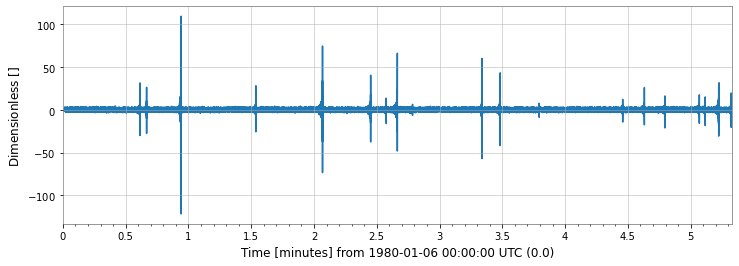

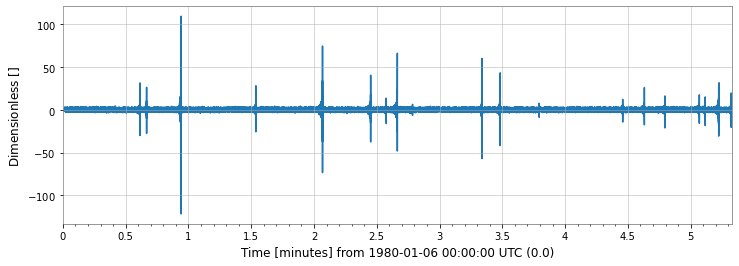

In [6]:
data_cbc[0].whiten().plot()